In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Its primary purpose is to configure Matplotlib to display plots directly 
#within the notebook's output cells, rather than in a separate window.

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split,GridSearchCV


In [4]:
train_df=pd.read_csv('/kaggle/input/titanic/train.csv')
test_df=pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()
#we dont need passengerid so we can remove it
#dtype w object we need to do sm about it


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [9]:
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
train_df.groupby(['Sex'],as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [13]:
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] +1
test_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] +1
#we are adding both the data from sibsp and oarch into one single index family size

In [14]:
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [15]:
family_map={ 1: 'Alone',2:'small',3 :'small',4 :'small',5 :'medium',6 :'medium',7:'medium',8:'large',9:'large',10:'large'}
train_df['Family_Size_Groupby']=train_df['Family_Size'].map(family_map)
test_df['Family_Size_Groupby']=train_df['Family_Size'].map(family_map)
#map is used to substitute the element in the bracket one by one

In [16]:
train_df.groupby(['Family_Size_Groupby'],as_index=False)['Survived'].mean()

,Family_Size_Groupby,Survived
0,Alone,0.303538
1,large,0.000000
2,medium,0.204082
3,small,0.578767


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

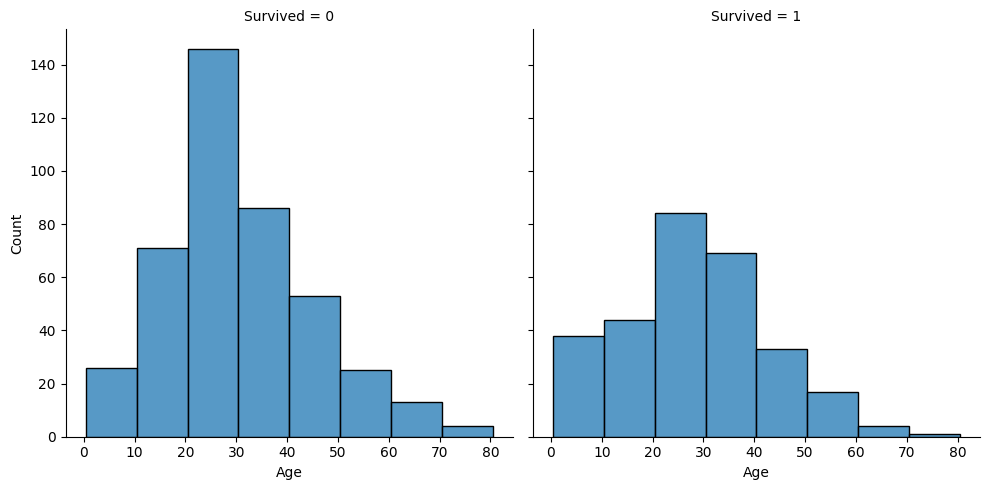

In [17]:
sns.displot(train_df, x='Age',col='Survived',binwidth=10,height=5)

In [18]:
train_df['Age_cut']=pd.qcut(train_df['Age'],8)
test_df['Age_cut']=pd.qcut(train_df['Age'],8)

In [19]:
train_df.groupby(['Age_cut'],as_index=False)['Survived'].mean()

/tmp/ipykernel_38/3684041627.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_cut'],as_index=False)['Survived'].mean()


,Age_cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [23]:
train_df.loc[train_df['Age'] <= 16 , 'Age'] = 0
train_df.loc[(train_df['Age'] > 16 ) & (train_df['Age']<= 20.125),'Age'] = 1
train_df.loc[(train_df['Age'] > 20.125 ) & (train_df['Age']<= 24.0),'Age'] = 2
train_df.loc[(train_df['Age'] >24.0 ) & (train_df['Age']<= 28),'Age'] = 3 
train_df.loc[(train_df['Age'] > 28 ) & (train_df['Age']<= 32.312),'Age'] = 4
train_df.loc[(train_df['Age'] > 32.312 ) & (train_df['Age']<= 38.0),'Age'] = 5
train_df.loc[(train_df['Age'] > 38 ) & (train_df['Age']<= 47.0),'Age'] = 6
train_df.loc[(train_df['Age'] > 47 ) & (train_df['Age']<= 80),'Age'] = 7
train_df.loc[train_df['Age'] > 80 , 'Age'] 

test_df.loc[test_df['Age'] <= 16 , 'Age'] = 0
test_df.loc[(test_df['Age'] > 16 ) & (test_df['Age']<=20.125),'Age'] = 1
test_df.loc[(test_df['Age'] > 20.125 ) & (test_df['Age']<=24.0),'Age'] = 2
test_df.loc[(test_df['Age'] >24.0 ) & (test_df['Age']<=28),'Age'] = 3 
test_df.loc[(test_df['Age'] > 28 ) & (test_df['Age']<=32.312),'Age'] = 4
test_df.loc[(test_df['Age'] > 32.312 ) & (test_df['Age']<=38.0),'Age'] = 5
test_df.loc[(test_df['Age'] > 38 ) & (test_df['Age']<=47.0),'Age'] = 6
test_df.loc[(test_df['Age'] > 47 ) & (test_df['Age']<=80),'Age'] = 7
test_df.loc[test_df['Age'] > 80 , 'Age'] 

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/exp

Series([], Name: Age, dtype: float64)

In [24]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Groupby,Age_cut
0,1,0,3,"Braund, Mr. Owen Harris",male,0.0,1,0,A/5 21171,7.2500,NaN,S,2,small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.0,1,0,PC 17599,71.2833,C85,C,2,small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,0.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.0,1,0,113803,53.1000,C123,S,2,small,"(32.312, 38.0]"
4,5,0,3,"Allen, Mr. William Henry",male,0.0,0,0,373450,8.0500,NaN,S,1,Alone,"(32.312, 38.0]"


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

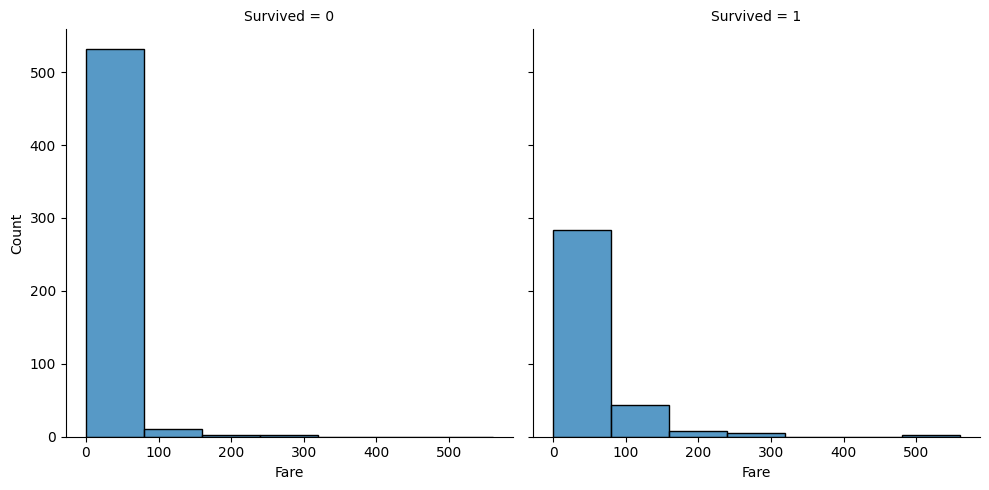

In [25]:
sns.displot( train_df,x='Fare',col='Survived',binwidth=80,height=5)

In [28]:
train_df['Fare_cut'] =pd.qcut(train_df['Fare'],6)
test_df['Fare_cut']=pd.qcut(test_df['Fare'],6)

In [29]:
train_df.groupby(['Fare_cut'],as_index=False)['Survived'].mean()

/tmp/ipykernel_38/1339538962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Fare_cut'],as_index=False)['Survived'].mean()


,Fare_cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [30]:
train_df.loc[train_df['Fare_cut'] <= 7.775 , 'Fare_cut'] = 0
train_df.loc[(train_df['Fare_cut'] > 7.775 ) & (train_df['Fare_cut']<=  8.662),'Fare_cut'] = 1
train_df.loc[(train_df['Fare_cut'] >  8.662 ) & (train_df['Fare_cut']<= 14.454),'Fare_cut'] = 2
train_df.loc[(train_df['Fare_cut'] >14.454 ) & (train_df['Fare_cut']<=  26.0),'Fare_cut'] = 3 
train_df.loc[(train_df['Fare_cut'] > 26.0 ) & (train_df['Fare_cut']<= 52.369),'Fare_cut'] = 4
train_df.loc[(train_df['Fare_cut'] > 52.369 ) & (train_df['Fare_cut']<= 512.329),'Fare_cut'] = 5
train_df.loc[train_df['Fare_cut'] > 512.329 , 'Fare_cut']

test_df.loc[test_df['Fare_cut'] <= 7.775 , 'Fare_cut'] = 0
test_df.loc[(test_df['Fare_cut'] > 7.775 ) & (test_df['Fare_cut']<=  8.662),'Fare_cut'] = 1
test_df.loc[(test_df['Fare_cut'] >  8.662 ) & (test_df['Fare_cut']<= 14.454),'Fare_cut'] = 2
test_df.loc[(test_df['Fare_cut'] >14.454 ) & (test_df['Fare_cut']<=  26.0),'Fare_cut'] = 3 
test_df.loc[(test_df['Fare_cut'] > 26.0 ) & (test_df['Fare_cut']<= 52.369),'Fare_cut'] = 4
test_df.loc[(test_df['Fare_cut'] > 52.369 ) & (test_df['Fare_cut']<= 512.329),'Fare_cut'] = 5
test_df.loc[test_df['Fare_cut'] > 512.329 , 'Fare_cut']

TypeError: Invalid comparison between dtype=category and float